In [1]:
#https://towardsdatascience.com/who-is-your-golden-goose-cohort-analysis-50c9de5dbd31
# import library
import pandas as pd
import numpy as np
import datetime as dt
import pyodbc 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:

cnn = pyodbc.connect('Driver={SQL Server Native Client 11.0};'
                      'Server=DESKTOP-ATL660H;'
                      'Database=AdventureWorksDW2012;'
                      'Trusted_Connection=yes;')

In [3]:
#Import Factinternetsales and DimProduct data from AHG SQL Datawarehouse
fis = pd.read_sql_query("""
SELECT
A.[SalesOrderNumber]
,A.[CustomerKey]
,B.[EnglishProductName] AS ProductName
,A.[ProductKey]
,A.[OrderQuantity]
,A.[UnitPrice]
,A.[OrderDate]
FROM [dbo].[FactInternetSales] AS A
LEFT JOIN [dbo].[DimProduct] AS B
ON A.[ProductKey] =B.[ProductKey]
""", cnn)

In [120]:
# ct = pd.read_sql_query("""
# SELECT
# [CustomerKey]
# ,[MaritalStatus]
# ,[Gender]
# FROM [dbo].[DimCustomer]""", cnn)

In [121]:
# #left join main data back to summarise sales reason data
# final_data = pd.merge(fis,
#                  ct,
#                  on='CustomerKey', how='left')

In [4]:
# final_data.head()
fis.head()

,SalesOrderNumber,CustomerKey,ProductName,ProductKey,OrderQuantity,UnitPrice,OrderDate
0,SO43697,21768,"Road-150 Red, 62",310,1,3578.2700,2010-12-29
1,SO43698,28389,"Mountain-100 Silver, 44",346,1,3399.9900,2010-12-29
2,SO43699,25863,"Mountain-100 Silver, 44",346,1,3399.9900,2010-12-29
3,SO43700,14501,"Road-650 Black, 62",336,1,699.0982,2010-12-29
4,SO43701,11003,"Mountain-100 Silver, 44",346,1,3399.9900,2010-12-29


In [5]:
# the number of customers
fis.CustomerKey.nunique()

18484

### RFM Values

 RFM (Recency, Frequency, Monetary) is a very Simple Technique that we can apply it very easy and get the super useful analysis for our Customer Segmentation. Recency is days since the customers made the last purchase and by definition, the lower it is the better. Frequency is the number of transaction in the last 12 months. Monetary value is the total amout of money the customers spent in the last 12 months

In [5]:
# extract year, month and day
fis['OrderDay'] = fis.OrderDate.apply(lambda x: dt.datetime(x.year, x.month, x.day))

In [6]:
print('Min : {}, Max : {}'.format(min(fis.OrderDate), max(fis.OrderDate)))

Min : 2010-12-29 00:00:00, Max : 2014-01-28 00:00:00


In [7]:
pin_date = max(fis.OrderDate) + dt.timedelta(1)

In [8]:
# Create total spend dataframe
fis['TotalSum'] = fis.OrderQuantity * fis.UnitPrice
fis.head()

,SalesOrderNumber,CustomerKey,ProductName,ProductKey,OrderQuantity,UnitPrice,OrderDate,OrderDay,TotalSum
0,SO43697,21768,"Road-150 Red, 62",310,1,3578.2700,2010-12-29,2010-12-29,3578.2700
1,SO43698,28389,"Mountain-100 Silver, 44",346,1,3399.9900,2010-12-29,2010-12-29,3399.9900
2,SO43699,25863,"Mountain-100 Silver, 44",346,1,3399.9900,2010-12-29,2010-12-29,3399.9900
3,SO43700,14501,"Road-650 Black, 62",336,1,699.0982,2010-12-29,2010-12-29,699.0982
4,SO43701,11003,"Mountain-100 Silver, 44",346,1,3399.9900,2010-12-29,2010-12-29,3399.9900


In [9]:
# calculate RFM values
rfm = fis.groupby('CustomerKey').agg({
    'OrderDate' : lambda x: (pin_date - x.max()).days,
    'SalesOrderNumber' : 'count', 
    'TotalSum' : 'sum'})

In [10]:
# rename the columns
rfm.rename(columns = {'OrderDate' : 'Recency', 
                      'SalesOrderNumber' : 'Frequency', 
                      'TotalSum' : 'Monetary'}, inplace = True)

rfm.head()

,Recency,Frequency,Monetary
CustomerKey,,,
11000,271,8,8248.99
11001,50,11,6383.88
11002,340,4,8114.04
11003,264,9,8139.29
11004,273,6,8196.01



As the three columns are grouped by customers and count the days from the max date value, Recency is the days since the last purchase of a customer. Frequency is the number of purchases of a customer and Monetary is the total amount of spend of a customer

 ### RFM quartiles


Let's group the customers based on Recency and Frequency. We will use quantile values to get three equal percentile groups an then make three separate gruops. As the lower Recency value is the better, we will label them in decreasing order

In [11]:
# create labels and assign them to tree percentile groups 
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 4, labels = r_labels)

f_labels = range(1, 5)
f_groups = pd.qcut(rfm.Frequency, q = 4, labels = f_labels)

m_labels = range(1, 5)
m_groups = pd.qcut(rfm.Monetary, q = 4, labels = m_labels)

m_groups.head()

CustomerKey
11000    4
11001    4
11002    4
11003    4
11004    4
Name: Monetary, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [12]:
# make a new column for group labels
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [13]:
# sum up the three columns
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerKey,,,,,,,,
11000,271,8,8248.99,1,4,4,144,9.0
11001,50,11,6383.88,4,4,4,444,12.0
11002,340,4,8114.04,1,3,4,134,8.0
11003,264,9,8139.29,2,4,4,244,10.0
11004,273,6,8196.01,1,4,4,144,9.0


With this value, we can go further analysis such as what is the average values for each RFM values or leveling customers in total RFM score.

In [14]:
# calculate averae values for each RFM_score
rfm_agg = rfm.groupby('RFM_Score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']
})

rfm_agg.round(1).head()

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3.0         315.3       1.6     22.9  1014
4.0         255.7       1.9     39.4  1490
5.0         258.4       2.0    473.5  2490
6.0         235.1       2.2    830.9  3022
7.0         178.0       2.9   1248.0  2508

In [15]:
# assign labels from total score
score_labels = ['Green', 'Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm.RFM_Score, q = 4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values

rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerKey,,,,,,,,,
11000,271,8,8248.99,1,4,4,144,9.0,Silver
11001,50,11,6383.88,4,4,4,444,12.0,Gold
11002,340,4,8114.04,1,3,4,134,8.0,Silver
11003,264,9,8139.29,2,4,4,244,10.0,Gold
11004,273,6,8196.01,1,4,4,144,9.0,Silver


### Customer Segmentation with Kmeans

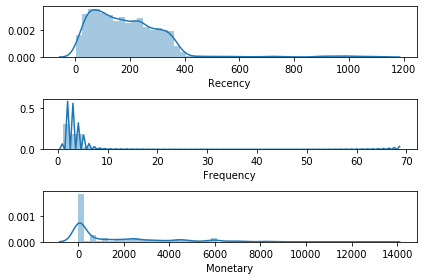

In [133]:

# plot the distribution of RFM values
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

In [16]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x

In [17]:
# apply the function to Recency and MonetaryValue column 
rfm['Recency'] = [neg_to_zero(x) for x in rfm.Recency]
rfm['Monetary'] = [neg_to_zero(x) for x in rfm.Monetary]
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerKey,,,,,,,,,
11000,271,8,8248.99,1,4,4,144,9.0,Silver
11001,50,11,6383.88,4,4,4,444,12.0,Gold
11002,340,4,8114.04,1,3,4,134,8.0,Silver
11003,264,9,8139.29,2,4,4,244,10.0,Gold
11004,273,6,8196.01,1,4,4,144,9.0,Silver


In [18]:
# unskew the data
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
rfm_log.head()

,Recency,Frequency,Monetary
CustomerKey,,,
11000,5.602,2.079,9.018
11001,3.912,2.398,8.762
11002,5.829,1.386,9.001
11003,5.576,2.197,9.004
11004,5.609,1.792,9.011


In [19]:
rfm_log.describe()

,Recency,Frequency,Monetary
count,18484.000000,18484.000000,18484.000000
mean,4.939616,1.013896,5.771886
std,0.902116,0.570010,2.182740
min,0.000000,0.000000,0.829000
25%,4.466000,0.693000,3.911000
50%,5.130000,1.099000,5.599500
75%,5.576000,1.386000,7.829000
max,7.027000,4.220000,9.495000


In [20]:
# scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [21]:
# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerKey,,,
11000,0.734276,1.868623,1.487214
11001,-1.139147,2.428277,1.369927
11002,0.985913,0.652821,1.479426
11003,0.705454,2.075642,1.480800
11004,0.742035,1.365109,1.484007


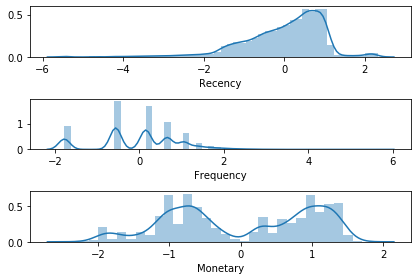

In [171]:
# plot the distribution of RFM values
plt.subplot(3, 1, 1); sns.distplot(rfm_scaled.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_scaled.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_scaled.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

### K-means clustering

In [22]:
# initiate an empty dictionary
#Within Cluster Sums of Squares (WCSS)
wcss = {}

# Elbow method with for loop
for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[i] = kmeans.inertia_

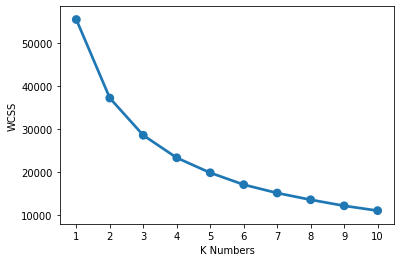

In [23]:
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [24]:
# choose n_clusters = 4
clus = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [25]:
# Assign the clusters to datamart
rfm['K_Cluster'] = clus.labels_
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
CustomerKey,,,,,,,,,,
11000,271,8,8248.9900,1,4,4,144,9.0,Silver,1
11001,50,11,6383.8800,4,4,4,444,12.0,Gold,1
11002,340,4,8114.0400,1,3,4,134,8.0,Silver,1
11003,264,9,8139.2900,2,4,4,244,10.0,Gold,1
11004,273,6,8196.0100,1,4,4,144,9.0,Silver,1
11005,272,6,8121.3300,1,4,4,144,9.0,Silver,1
11006,260,5,8119.0300,2,4,4,244,10.0,Gold,1
11007,316,8,8211.0000,1,4,4,144,9.0,Silver,1
11008,333,7,8106.3100,1,4,4,144,9.0,Silver,1


#### Snake Plot
In marketing, snail plot and heatmap are often used plot for visualization. I'll use the rfm_scaled dataframe with normalized rfm values for the plot.

In [26]:
# assign cluster column 
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)

In [27]:
rfm_scaled.head()

,CustomerKey,Recency,Frequency,Monetary,K_Cluster,RFM_Level
0,11000,0.734276,1.868623,1.487214,1,Silver
1,11001,-1.139147,2.428277,1.369927,1,Gold
2,11002,0.985913,0.652821,1.479426,1,Silver
3,11003,0.705454,2.075642,1.480800,1,Gold
4,11004,0.742035,1.365109,1.484007,1,Silver


In [41]:
# melt the dataframe
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['CustomerKey', 'RFM_Level', 'K_Cluster'], 
                     var_name = 'Metrics', value_name = 'Value')
rfm_melted

,CustomerKey,RFM_Level,K_Cluster,Metrics,Value
0,11000,Silver,1,Recency,0.734276
1,11001,Gold,1,Recency,-1.139147
2,11002,Silver,1,Recency,0.985913
3,11003,Gold,1,Recency,0.705454
4,11004,Silver,1,Recency,0.742035
5,11005,Silver,1,Recency,0.738710
6,11006,Gold,1,Recency,0.688826
7,11007,Silver,1,Recency,0.904990
8,11008,Silver,1,Recency,0.962634
9,11009,Silver,1,Recency,0.709888


In [43]:
#rfm_melted.to_csv(rfm_data, encoding='utf-8', index=False)
#rfm_melted.to_csv (r'C:\Users\SHAH/rfm_data.csv', index = False, header=True)


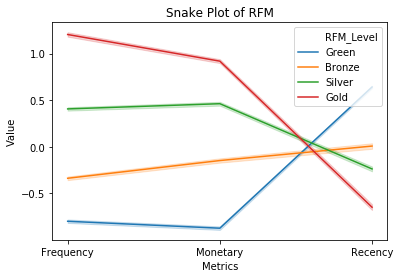

In [30]:
# a snake plot with RFM
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

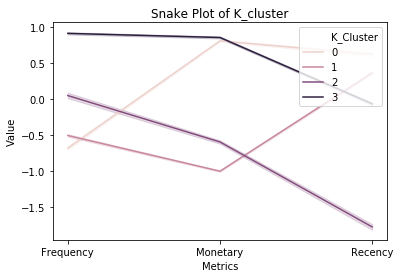

In [35]:
# a snake plot with K-Means
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of K_cluster')
plt.legend(loc = 'upper right')

#### Heatmap
Heatmap is efficient for comparing the standardized values.

In [31]:
# the mean value for each cluster
cluster_avg = rfm.groupby('RFM_Level').mean().iloc[:, 0:3]
cluster_avg.head()

,Recency,Frequency,Monetary
RFM_Level,,,
Green,269.147978,1.879055,252.495528
Bronze,209.236347,2.481374,1020.075202
Silver,147.131478,3.711991,2044.690174
Gold,100.242857,6.065957,3923.402910


In [32]:
# the mean value in total 
total_avg = rfm.iloc[:, 0:3].mean()
total_avg

Recency       190.332450
Frequency       3.267583
Monetary     1588.329216
dtype: float64

In [33]:
# the proportional mean value
prop_rfm = cluster_avg/total_avg - 1
prop_rfm

,Recency,Frequency,Monetary
RFM_Level,,,
Green,0.414094,-0.424940,-0.841031
Bronze,0.099320,-0.240609,-0.357768
Silver,-0.226976,0.136005,0.287321
Gold,-0.473328,0.856405,1.470145


[]

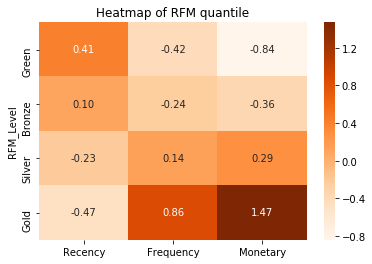

In [34]:
# heatmap
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True)
plt.title('Heatmap of RFM quantile')
plt.plot()

In [35]:

# the mean value for each cluster
cluster_avg_K = rfm.groupby('K_Cluster').mean().iloc[:, 0:3]

# the proportional mean value
prop_rfm_K = cluster_avg_K/total_avg - 1
prop_rfm_K

,Recency,Frequency,Monetary
K_Cluster,,,
0,0.122611,-0.309748,-0.968741
1,-0.172085,0.535524,1.084262
2,0.615339,-0.383117,0.489300
3,-0.806424,0.033418,-0.835201


[]

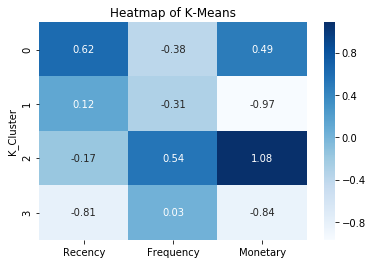

In [159]:
# heatmap
sns.heatmap(prop_rfm_K, cmap= 'Blues', fmt= '.2f', annot = True)
plt.title('Heatmap of K-Means')
plt.plot()

### Saving the rfm data as CSV file to merge with Churn data

In [49]:
# check rfm data
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
CustomerKey,,,,,,,,,,
11000,271,8,8248.99,1,4,4,144,9.0,Silver,1
11001,50,11,6383.88,4,4,4,444,12.0,Gold,1
11002,340,4,8114.04,1,3,4,134,8.0,Silver,1
11003,264,9,8139.29,2,4,4,244,10.0,Gold,1
11004,273,6,8196.01,1,4,4,144,9.0,Silver,1


In [52]:
#rfm.to_csv(rfm_data, encoding='utf-8', index=False)
rfm.reset_index(inplace = True)
rfm

,CustomerKey,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
0,11000,271,8,8248.9900,1,4,4,144,9.0,Silver,1
1,11001,50,11,6383.8800,4,4,4,444,12.0,Gold,1
2,11002,340,4,8114.0400,1,3,4,134,8.0,Silver,1
3,11003,264,9,8139.2900,2,4,4,244,10.0,Gold,1
4,11004,273,6,8196.0100,1,4,4,144,9.0,Silver,1
5,11005,272,6,8121.3300,1,4,4,144,9.0,Silver,1
6,11006,260,5,8119.0300,2,4,4,244,10.0,Gold,1
7,11007,316,8,8211.0000,1,4,4,144,9.0,Silver,1
8,11008,333,7,8106.3100,1,4,4,144,9.0,Silver,1
9,11009,265,5,8091.3300,1,4,4,144,9.0,Silver,1


In [54]:
#save rfm data to csv in home directroy
rfm.to_csv (r'C:\Users\SHAH/rfm.csv', index = False, header=True)


In [45]:
df.head()

,CustomerKey,RFM_Level,K_Cluster,Metrics,Value
0,11000,Silver,1,Recency,0.734276
1,11001,Gold,1,Recency,-1.139147
2,11002,Silver,1,Recency,0.985913
3,11003,Gold,1,Recency,0.705454
4,11004,Silver,1,Recency,0.742035
